In [ ]:
import joblib
from tensorflow.keras.models import load_model
import numpy as np

# Load the saved model
#f'Knowledge/{self.problem_type}/{self.source}/{self.file_name}/models/RFC_model_{self.target_variable}.joblib
model = load_model('Knowledge/time series/xls/Combined_combined_data.csv/models/LSTM_model_BG.h5')

# Load the scaler
scaler = joblib.load('Knowledge/time series/xls/Combined_combined_data.csv/models/scaler_x.pkl')

# Assuming you have a new_data array for prediction
# Define the data point
Unnamed = 0
time = "10/25/2023 6:00"
bg = 126.0139434
cgm = 136.4350328
cho = 0
insulin = 0.013933333
lbgi = 0
hbgi = 0.446600306
risk = 0.446600306
patient = "adolescent"

# Fill in the new_data array
new_data = np.array([
    [Unnamed,bg, cgm, cho, insulin, lbgi, hbgi, risk]  # Assuming this represents one time step
])

# Scale the new data
scaled_new_data = scaler.transform(new_data)

# Reshape the data to match the input shape of the LSTM model
sequence_length = 5 # Set this to the sequence length used during training
num_features =len(df.columns)  # Set this to the number of features used during training
X_data = []
for i in range(len(scaled_new_data) - sequence_length):
    X_data.append(scaled_new_data[i:(i + sequence_length), :-1])
X_data = np.array(X_data)

# Make predictions
predictions = model.predict(X_data)

print(predictions)


In [ ]:
import numpy as np
import joblib
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

# Dummy data generation
np.random.seed(0)  # For reproducibility
num_samples = 20
num_features = 5  # Assuming 7 features similar to your original data
sequence_length = 5  # Assuming sequence length of 5

dummy_data = np.random.rand(num_samples, num_features)  # Dummy features

# Print the first few rows of dummy data
print(dummy_data[:5])

# Load the saved model
model_path = 'Knowledge/time series/xls/Combined_combined_data.csv/models/LSTM_model_BG.h5'
model = load_model(model_path)

# Load the scaler
scaler_path = 'Knowledge/time series/xls/Combined_combined_data.csv/models/scaler_x.pkl'
scaler = joblib.load(scaler_path)

# Create a new MinMaxScaler with the correct number of features
scaler = MinMaxScaler(feature_range=(0, 1))  # Adjust feature_range if needed
scaler.fit(dummy_data)

# Scale the dummy data using the new scaler
scaled_dummy_data = scaler.transform(dummy_data)

X_data = []
for i in range(len(scaled_dummy_data) - sequence_length + 1):
    X_data.append(scaled_dummy_data[i:(i + sequence_length)])
X_data = np.array(X_data)

# Make sure to reshape X_data to add the batch dimension
X_data = np.reshape(X_data, (X_data.shape[0], X_data.shape[1], num_features))  # Assuming num_features is 7

# Make predictions
predictions = model.predict(X_data)

print(predictions)


# new time series

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [ ]:
path = 'Bussiness_facility/combined_data.csv'

In [ ]:
df = pd.read_csv(path)

In [ ]:
df.info()

In [ ]:
df.head()

In [ ]:
df.tail()

In [ ]:
df1 = df.reset_index()['BG']

In [ ]:
df1

In [ ]:
df1.shape

In [ ]:
plt.plot(df1)

## min max scaler

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler= MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
df1.shape

## Train Test Split

In [ ]:
training_size = int(len(df1)*0.65)
test_size = len(df1)-training_size
train_data,test_data = df1[0:training_size,:],df1[training_size:len(df1),:1]

In [ ]:
train_data.shape,test_data.shape

In [ ]:
import numpy
def create_dataset(dataset,time_step=1):
    dataX,dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step),0]     #i=0, 0,1,2,3
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])
    return numpy.array(dataX), numpy.array(dataY)
        

In [ ]:
#reshape into 
time_step =100
X_train,y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [ ]:
print(X_train.shape)

In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model.summary()

In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64,verbose=1)

# Predictions

In [ ]:
#prediction
train_predict =  model.predict(X_train)
test_predict = model.predict(X_test)

In [ ]:
#Transformback to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [ ]:
print(test_predict[:5])

## calculate RMSE performace

In [ ]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

In [ ]:
## Test Data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

## Train Vs Test Data

In [ ]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## prediction next 10 days

In [ ]:
len(test_data)

In [ ]:
x_input=test_data[10988:].reshape(1,-1)
x_input.shape

In [ ]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [ ]:
# Define the number of future days to predict
num_days = 30
n_steps = 100
# Initialize temp_input with the last known values from your dataset

# Predict future values for each day in the specified range
predicted_values_scaled = []  # Store scaled predicted values
for i in range(num_days):
    x_input = np.array(temp_input).reshape((1, n_steps, 1))
    yhat = model.predict(x_input, verbose=0)
    temp_input = np.append(temp_input[1:], yhat[0])  # Update temp_input for the next prediction
    predicted_values_scaled.append(yhat[0])

# Inverse scale the predicted values
predicted_values = scaler.inverse_transform(np.array(predicted_values_scaled).reshape(-1, 1)).flatten()

# Print and plot the predicted values
for i, pred in enumerate(predicted_values):
    print("Day {}: Predicted BG value = {}".format(i + 1, pred))

# new test

In [ ]:
path = 'Bussiness_facility/combined_data.csv'
df = pd.read_csv(path, parse_dates=['Time'])

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('Bussiness_facility/combined_data.csv')

# Convert the 'Time' column to datetime
data['Time'] = pd.to_datetime(data['Time'], errors='coerce')

# Set the 'Time' column as the index
data.set_index('Time', inplace=True)

# Function to prepare data for LSTM
def prepare_data_for_lstm(data, target_column, look_back=1):
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(data[[target_column]])

    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y), scaler

# Function to create LSTM model
def create_lstm_model(look_back):
    model = Sequential()
    model.add(LSTM(units=50, input_shape=(look_back, 1)))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Function to perform time series forecasting using LSTM
def forecast_lstm(data, target_column, look_back=1, epochs=10, batch_size=1, forecast_period=10):
    X, Y, scaler = prepare_data_for_lstm(data, target_column, look_back)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    model = create_lstm_model(look_back)
    model.fit(X, Y, epochs=epochs, batch_size=batch_size, verbose=2)

    # Make predictions for forecast period
    last_input = X[-1]
    forecast_data = []
    for _ in range(forecast_period):
        prediction = model.predict(np.reshape(last_input, (1, look_back, 1)))
        forecast_data.append(prediction[0][0])
        last_input = np.append(last_input[1:], prediction[0])

    # Inverse transform the forecast predictions
    forecast_data = scaler.inverse_transform(np.array(forecast_data).reshape(-1, 1))
    print("Forecasted data:")
    print(forecast_data)
    return forecast_data



In [ ]:
# Example usage
target_column = 'BG'  # Specify the target column name
forecast_period = 10  # Specify the forecast period
look_back = 1  # Specify the number of timesteps to look back

forecast_lstm(data, target_column, look_back=look_back, forecast_period=forecast_period)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('Bussiness_facility/combined_data.csv')

# Convert the 'Time' column to datetime
data['Time'] = pd.to_datetime(data['Time'], errors='coerce')

# Remove the 'Time' column before setting it as the index
data.set_index('Time', inplace=True)

# Function to prepare data for LSTM
def prepare_data_for_lstm(data, target_column, look_back=1):
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(data[[target_column]])

    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y), scaler

# Function to create LSTM model
def create_lstm_model(look_back):
    model = Sequential()
    model.add(LSTM(units=50, input_shape=(look_back, 1)))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Function to perform time series forecasting using LSTM
def forecast_lstm(data, target_column, look_back=1, epochs=10, batch_size=1, forecast_period=10):
    X, Y, scaler = prepare_data_for_lstm(data, target_column, look_back)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    model = create_lstm_model(look_back)
    model.fit(X, Y, epochs=epochs, batch_size=batch_size, verbose=2)

    # Make predictions for forecast period
    last_input = X[-1]
    forecast_data = []
    for _ in range(forecast_period):
        prediction = model.predict(np.reshape(last_input, (1, look_back, 1)))
        forecast_data.append(prediction[0][0])
        last_input = np.append(last_input[1:], prediction[0])

    # Inverse transform the forecast predictions
    forecast_data = scaler.inverse_transform(np.array(forecast_data).reshape(-1, 1))
    print(forecast_data)

# Define the forecast period
start_date = '2023-10-26 12:25:00'
end_date = '2023-11-26 12:25:00'

# Filter the data for the forecast period
forecast_data = data[start_date:end_date]

# Perform forecasting
forecast_lstm(forecast_data, target_column='BG', look_back=1, epochs=10, batch_size=1, forecast_period=10)


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

class ConversationGenerator:
    def __init__(self, model_name_or_path):
        self.model = AutoModelForCausalLM.from_pretrained(model_name_or_path, device_map="auto")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
    
    def generate_response(self, user_question, system_prompt_question, max_tokens=100):
        conversation = [
            {"role": "user", "content": user_question},
            {"role": "assistant", "content": system_prompt_question}
        ]
        
        model_inputs = self.tokenizer.apply_chat_template(conversation, return_tensors="pt").to("cuda")
        generated_ids = self.model.generate(model_inputs, max_new_tokens=max_tokens, do_sample=True)
        response = self.tokenizer.batch_decode(generated_ids)[0]
        
        return response
    
    def introduction(self, user_question):
        system_prompt_question = "Can you introduce yourself?"
        user_question = "Can you introduce yourself?"
        return self.generate_response(user_question, system_prompt_question)
    
    def summary(self, user_question):
        system_prompt_question = "Can you provide a summary?"
        user_question = "Can you provide a summary?"
        return self.generate_response(user_question, system_prompt_question)

# Example usage:
generator = ConversationGenerator("mistralai/Mistral-7B-Instruct-v0.2")

# Introduction

response = generator.introduction(user_question)
print("Introduction:", response)


In [ ]:
# Summary

response = generator.summary(user_question)
print("Summary:", response)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('Bussiness_facility/combined_data.csv')

# Convert the 'Time' column to datetime
data['Time'] = pd.to_datetime(data['Time'], errors='coerce')

# Remove the 'Time' column before setting it as the index
data.set_index('Time', inplace=True)

# Function to prepare data for LSTM
def prepare_data_for_lstm(data, target_column, look_back=1):
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(data[[target_column]])

    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y), scaler

# Function to create LSTM model
def create_lstm_model(look_back):
    model = Sequential()
    model.add(LSTM(units=50, input_shape=(look_back, 1)))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Function to perform time series forecasting using LSTM
def forecast_lstm(data, time_column, target_column, look_back=1, epochs=10, batch_size=1, forecast_period=10):
    X, Y, scaler = prepare_data_for_lstm(data, target_column, look_back)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    model = create_lstm_model(look_back)
    model.fit(X, Y, epochs=epochs, batch_size=batch_size, verbose=2)

    # Make predictions for forecast period
    last_input = X[-1]
    forecast_data = []
    for _ in range(forecast_period):
        prediction = model.predict(np.reshape(last_input, (1, look_back, 1)))
        forecast_data.append(prediction[0][0])
        last_input = np.append(last_input[1:], prediction[0])

    # Inverse transform the forecast predictions
    forecast_data = scaler.inverse_transform(np.array(forecast_data).reshape(-1, 1))
    return forecast_data

# Define the forecast period
start_date = '2023-10-26 12:25:00'
end_date = '2023-11-26 12:25:00'

# Prompt user to input target column and time column
target_column = input("Enter the target column: ")
time_column = input("Enter the time column: ")

# Filter the data for the forecast period
forecast_data = data[start_date:end_date]

# Perform forecasting
forecasted_values = forecast_lstm(forecast_data, time_column=time_column, target_column=target_column, look_back=1, epochs=10, batch_size=1, forecast_period=100)

# Plot the original data and forecasted values
plt.figure(figsize=(10, 6))
plt.plot(data.index, data[target_column], label='Original Data')

# Extract the last timestamp from the forecast_data index
last_timestamp = forecast_data.index[-1].to_pydatetime()

# Print the last timestamp for debugging
print("Last Timestamp:", last_timestamp)

# Generate date range for forecasted values
forecast_date_range = pd.date_range(start=last_timestamp, periods=len(forecasted_values), freq='D')

# Print the forecast date range for debugging
print("Forecast Date Range:", forecast_date_range)

# Plot the forecasted values with the correct date range
plt.plot(forecast_date_range, forecasted_values, label='Forecasted Data')
plt.xlabel(time_column)
plt.ylabel(target_column)
plt.title('Original vs Forecasted Data')
plt.legend()
plt.show()

In [ ]:
print(len(forecasted_values) )

In [ ]:
# Plot the original data and forecasted values
plt.figure(figsize=(10, 6))
plt.plot(data.index, data[target_column], label='Original Data')

# Extract the last timestamp from the forecast_data index
last_timestamp = forecast_data.index[-1].to_pydatetime()

# Print the last timestamp for debugging
print("Last Timestamp:", last_timestamp)

# Generate date range for forecasted values
forecast_date_range = pd.date_range(start=last_timestamp, periods=len(forecasted_values), freq='D')

# Print the forecast date range for debugging
print("Forecast Date Range:", forecast_date_range)

# Plot the forecasted values with the correct date range
plt.plot(forecast_date_range, forecasted_values, label='Forecasted Data')
plt.xlabel(time_column)
plt.ylabel(target_column)
plt.title('Original vs Forecasted Data')
plt.legend()
plt.show()


In [ ]:
# Print the timestamp along with the corresponding forecasted value
for timestamp, value in zip(forecast_date_range, forecasted_values):
    print("Timestamp:", timestamp, "| Forecasted Value:", value)


# NEW

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('Bussiness_facility/combined_data.csv')

# Convert the 'Time' column to datetime
data['Time'] = pd.to_datetime(data['Time'], errors='coerce')

# Remove the 'Time' column before setting it as the index
data.set_index('Time', inplace=True)

# Function to prepare data for LSTM
def prepare_data_for_lstm(data, target_column, look_back=1):
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(data[[target_column]])

    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y), scaler

# Function to create LSTM model
def create_lstm_model(look_back):
    model = Sequential()
    model.add(LSTM(units=50, input_shape=(look_back, 1)))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Function to perform time series forecasting using LSTM
def forecast_lstm(data, target_column, look_back=1, epochs=10, batch_size=1, forecast_period=10):
    X, Y, scaler = prepare_data_for_lstm(data, target_column, look_back)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    model = create_lstm_model(look_back)
    model.fit(X, Y, epochs=epochs, batch_size=batch_size, verbose=2)

    # Make predictions for forecast period
    last_input = X[-1]
    forecast_data = []
    for _ in range(forecast_period):
        prediction = model.predict(np.reshape(last_input, (1, look_back, 1)))
        forecast_data.append(prediction[0][0])
        last_input = np.append(last_input[1:], prediction[0])

    # Inverse transform the forecast predictions
    forecast_data = scaler.inverse_transform(np.array(forecast_data).reshape(-1, 1))
    return forecast_data

# Prompt user to input target column
target_column = input("Enter the target column: ")

# Prompt user to input time column
time_column = input("Enter the time column: ")

# Define the prediction date
prediction_date = pd.to_datetime('2025-11-26 12:25:00')

# Filter the data for training up to the date just before the prediction date
historical_data = data[data.index < prediction_date]

# Perform forecasting
forecasted_value = forecast_lstm(historical_data, target_column=target_column, look_back=1, epochs=10, batch_size=1, forecast_period=1)

# Print the forecasted value
print("Forecasted Value for", prediction_date, ":", forecasted_value[0])


# T VS F

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
import joblib

# Load the dataset
data = pd.read_csv('Bussiness_facility/combined_data.csv')

# Convert the 'Time' column to datetime
data['Time'] = pd.to_datetime(data['Time'], errors='coerce')

# Remove the 'Time' column before setting it as the index
data.set_index('Time', inplace=True)

# Function to prepare data for LSTM
def prepare_data_for_lstm(data, target_column, look_back=1):
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(data[[target_column]])

    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y), scaler

# Function to create LSTM model
def create_lstm_model(look_back):
    model = Sequential()
    model.add(LSTM(units=50, input_shape=(look_back, 1)))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Function to train and save LSTM model
def train_and_save_model(data, target_column, look_back=1, epochs=10, batch_size=1):
    X, Y, scaler = prepare_data_for_lstm(data, target_column, look_back)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    model = create_lstm_model(look_back)
    model.fit(X, Y, epochs=epochs, batch_size=batch_size, verbose=2)
    
    # Save the trained model
    model.save('time_series_testing_model/trained_model.h5')
    
    # Save the scaler object
    joblib.dump(scaler, 'time_series_testing_model/scaler.pkl')

# Prompt user to input target column
target_column = input("Enter the target column: ")

# Train and save the model
train_and_save_model(data, target_column=target_column, look_back=1, epochs=10, batch_size=1)


Enter the time series column: Time
Enter the target column: BG
Epoch 1/10


2024-04-22 15:27:34.602173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-22 15:27:34.603448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-22 15:27:34.604969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

31679/31679 - 112s - loss: 4.5040e-04 - 112s/epoch - 4ms/step
Epoch 2/10
31679/31679 - 111s - loss: 1.9896e-04 - 111s/epoch - 3ms/step
Epoch 3/10
31679/31679 - 107s - loss: 1.9653e-04 - 107s/epoch - 3ms/step
Epoch 4/10
31679/31679 - 107s - loss: 1.9059e-04 - 107s/epoch - 3ms/step
Epoch 5/10
31679/31679 - 108s - loss: 1.8901e-04 - 108s/epoch - 3ms/step
Epoch 6/10
31679/31679 - 112s - loss: 1.8797e-04 - 112s/epoch - 4ms/step
Epoch 7/10
31679/31679 - 109s - loss: 1.8841e-04 - 109s/epoch - 3ms/step
Epoch 8/10
31679/31679 - 111s - loss: 1.8508e-04 - 111s/epoch - 3ms/step
Epoch 9/10
31679/31679 - 107s - loss: 1.8418e-04 - 107s/epoch - 3ms/step
Epoch 10/10
31679/31679 - 108s - loss: 1.8331e-04 - 108s/epoch - 3ms/step


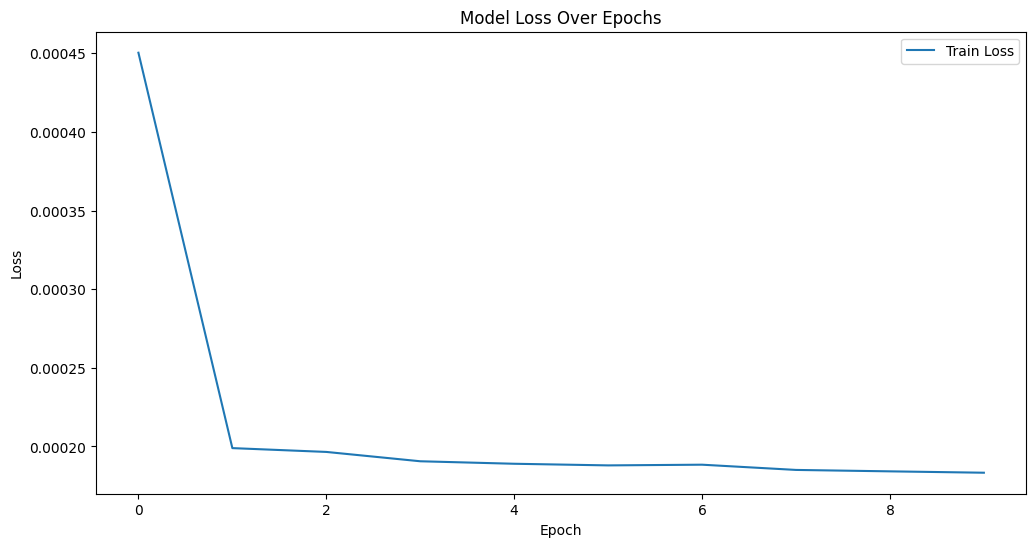

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
import joblib
import matplotlib.pyplot as plt
# Load the dataset
file_path = 'Bussiness_facility/Diabeties.csv'
data = pd.read_csv(file_path)

# Prompt user to input the time series column
time_series_column = input("Enter the time series column: ")

# Prompt user to input the target column
target_column = input("Enter the target column: ")

# Convert the time series column to datetime
data[time_series_column] = pd.to_datetime(data[time_series_column], errors='coerce')

# Remove the time series column before setting it as the index
data.set_index(time_series_column, inplace=True)

# Function to prepare data for LSTM
def prepare_data_for_lstm(data, target_column, look_back=1):
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(data[[target_column]])

    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y), scaler

# Function to create LSTM model
def create_lstm_model(look_back):
    model = Sequential()
    model.add(LSTM(units=50, input_shape=(look_back, 1)))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Function to train and save LSTM model
def train_and_save_model(data, target_column, look_back=1, epochs=10, batch_size=1):
    X, Y, scaler = prepare_data_for_lstm(data, target_column, look_back)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    model = create_lstm_model(look_back)
    history = model.fit(X, Y, epochs=epochs, batch_size=batch_size, verbose=2)
                # Plot training loss
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.title('Model Loss Over Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
#     loss_graph_path = f'Knowledge/{self.problem_type}/{self.source}/{self.file_name}/graphs/LSTM_training_loss_graph_{self.dependent_var}.png'
#     self.dict_manager.update_value("LSTM Training loss graph", loss_graph_path)
#     plt.savefig(loss_graph_path)
    plt.show()
    # Save the trained model
    model.save('time_series_testing_model/trained_model.h5')
    
    # Save the scaler object
    joblib.dump(scaler, 'time_series_testing_model/scaler.pkl')

# Train and save the model
train_and_save_model(data, target_column=target_column, look_back=1, epochs=10, batch_size=1)


# With label Encodder

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import joblib

# Load the dataset
file_path = input("Enter the file path of the dataset: ")
data = pd.read_csv(file_path)

# Prompt user to input the time series column
time_series_column = input("Enter the time series column: ")

# Prompt user to input the target column
target_column = input("Enter the target column: ")

# Convert the time series column to datetime
data[time_series_column] = pd.to_datetime(data[time_series_column], errors='coerce')

# Remove the time series column before setting it as the index
data.set_index(time_series_column, inplace=True)

# Function to handle categorical data using Label Encoding
def handle_categorical_data(data):
    categorical_columns = data.select_dtypes(include=['object']).columns
    label_encoders = {}
    if len(categorical_columns) > 0:
        for column in categorical_columns:
            label_encoder = LabelEncoder()
            data[column] = label_encoder.fit_transform(data[column])
            label_encoders[column] = label_encoder
    return data, label_encoders

# Handle categorical data and get label encoders
data, label_encoders = handle_categorical_data(data)

# Function to prepare data for LSTM
def prepare_data_for_lstm(data, target_column, look_back=1):
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(data[[target_column]])

    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y), scaler

# Function to create LSTM model
def create_lstm_model(look_back):
    model = Sequential()
    model.add(LSTM(units=50, input_shape=(look_back, 1)))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Function to train and save LSTM model
def train_and_save_model(data, target_column, look_back=1, epochs=10, batch_size=1):
    X, Y, scaler = prepare_data_for_lstm(data, target_column, look_back)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    model = create_lstm_model(look_back)
    model.fit(X, Y, epochs=epochs, batch_size=batch_size, verbose=2)
    
    # Save the trained model
    model.save('time_series_testing_model/trained_model.h5')
    
    # Save the scaler object
    joblib.dump(scaler, 'time_series_testing_model/scaler.pkl')
    
    # Save the label encoders
    joblib.dump(label_encoders, 'time_series_testing_model/label_encoders.pkl')

# Train and save the model
train_and_save_model(data, target_column=target_column, look_back=1, epochs=10, batch_size=1)


# simple

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import joblib

# Load the dataset
file_path = 'Bussiness_facility/sample_Data.csv'
data = pd.read_csv(file_path)

# Prompt user to input the time series column
time_series_column = input("Enter the time series column: ")

# Prompt user to input the target column
target_column = input("Enter the target column: ")

# Convert the time series column to datetime
data[time_series_column] = pd.to_datetime(data[time_series_column], errors='coerce')

# Remove the time series column before setting it as the index
data.set_index(time_series_column, inplace=True)



In [ ]:
data

In [ ]:
# Prepare data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(data[[target_column]])

In [ ]:
dataset

In [ ]:
len(dataset)
dataset.shape

In [ ]:
look_back = 1
X, Y = [], []
for i in range(len(dataset) - look_back):
    X.append(dataset[i:(i + look_back), 0])
    Y.append(dataset[i + look_back, 0])
X, Y = np.array(X), np.array(Y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Create LSTM model
model = Sequential()
model.add(LSTM(units=50, input_shape=(look_back, 1)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
epochs = 10
batch_size = 1
model.fit(X, Y, epochs=epochs, batch_size=batch_size, verbose=2)

# Save the trained model
model.save('time_series_testing_model/trained_model.h5')

# Save the scaler object
joblib.dump(scaler, 'time_series_testing_model/scaler.pkl')


In [2]:
import pandas as pd
df= pd.read_csv("Knowledge/time series/xls/Combined_Combined_combined_data.csv/dataset/Combined_Combined_combined_data.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31680 entries, 0 to 31679
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    31680 non-null  int64  
 1   Unnamed: 0.1  31680 non-null  int64  
 2   Time          31680 non-null  object 
 3   BG            31680 non-null  float64
 4   CGM           31680 non-null  float64
 5   CHO           31680 non-null  float64
 6   insulin       31680 non-null  float64
 7   LBGI          31680 non-null  float64
 8   HBGI          31680 non-null  float64
 9   Risk          31680 non-null  float64
 10  Patient       31680 non-null  object 
dtypes: float64(7), int64(2), object(2)
memory usage: 2.7+ MB


In [4]:
import pandas as pd
df= pd.read_csv("Bussiness_facility/Combined_combined_data.csv")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31680 entries, 0 to 31679
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0.1  31680 non-null  int64  
 1   Unnamed: 0    31680 non-null  int64  
 2   Time          31680 non-null  object 
 3   BG            31680 non-null  float64
 4   CGM           31680 non-null  float64
 5   CHO           31680 non-null  float64
 6   insulin       31680 non-null  float64
 7   LBGI          31680 non-null  float64
 8   HBGI          31680 non-null  float64
 9   Risk          31680 non-null  float64
 10  Patient       31680 non-null  object 
dtypes: float64(7), int64(2), object(2)
memory usage: 2.7+ MB
